# Normalization

Normalization is a fundamental principle in relational database design that ensures data integrity, eliminates redundancy, and creates maintainable schemas. Understanding normalization helps you design databases that are robust, efficient, and accurately represent your domain.


## Why Normalization Matters

Poor database design leads to serious problems:

1. **Update Anomalies**: When the same data is stored in multiple places, updates must be made in all locations or inconsistencies arise
2. **Insertion Anomalies**: Cannot add certain data without having other, unrelated data present
3. **Deletion Anomalies**: Deleting one piece of information inadvertently removes other important data
4. **Data Redundancy**: Unnecessary duplication wastes storage and creates maintenance overhead

**Example of unnormalized data:**

```
Employee Project Table (BAD DESIGN)
┌─────────────┬──────────┬────────────┬─────────────┬──────────────┐
│ project_id* │ emp_name │ dept_name  │ dept_phone  │ project_name │
├─────────────┼──────────┼────────────┼─────────────┼──────────────┤
│ P1          │ Alice    │ Engineering│ 555-0100    │ Database     │
│ P2          │ Alice    │ Engineering│ 555-0100    │ API          │
│ P3          │ Bob      │ Sales      │ 555-0200    │ Marketing    │
└─────────────┴──────────┴────────────┴─────────────┴──────────────┘

Problems:
- Alice's department info is duplicated (redundancy)
- If department phone changes, must update multiple rows (update anomaly)
- Cannot add a department without a project (insertion anomaly)
- Deleting last project removes department info (deletion anomaly)
```

Normalization solves these problems by organizing data into well-structured tables.


## Classical Normalization Theory

Edgar F. Codd developed formal normalization theory in the early 1970s, **before** the Entity-Relationship model existed. His approach is based on **functional dependencies** between attributes and provides mathematical rigor for database design.

The classical normal forms form a progression, each building on the previous one and addressing specific types of problems [@10.1145/358024.358054]. Let's examine each with examples.


### First Normal Form (1NF)

**Definition**: All attributes must contain **atomic (indivisible) values**. No repeating groups or arrays.

**Problem**: Non-atomic values make it difficult to query specific items and violate the relational model's requirement that each cell contains a single value.

**Example - Violation of 1NF:**

```
Student Course Registration (VIOLATES 1NF)
┌─────────────┬──────────┬─────────────────────────┐
│ student_id* │ name     │ courses                 │
├─────────────┼──────────┼─────────────────────────┤
│ 1           │ Alice    │ Math, Physics, Chemistry│  ← Non-atomic!
│ 2           │ Bob      │ Physics, Biology        │  ← Non-atomic!
└─────────────┴──────────┴─────────────────────────┘

Student Course Registration (VIOLATES 1NF)
┌─────────────┬──────────┬──────────┬─────────┬──────────┐
│ student_id* │ name     │ course1  | course2 | course3  │
├─────────────┼──────────┼──────────┼─────────┼──────────┤
│ 1           │ Alice    │ Math     | Physics | Chemistry│  ← Repeated groups
│ 2           │ Bob      │ Physics  | Biology │ NULL     │
└─────────────┴──────────┴──────────┴─────────┴──────────┘


Problem: Cannot easily query "who is taking Physics?"
```

**Normalized to 1NF:**

```
Student table:               Enrollment table:
┌─────────────┬──────────┐   ┌─────────────┬───────────┐
│ student_id* │ name     │   │ student_id* │ course*   │
├─────────────┼──────────┤   ├─────────────┼───────────┤
│ 1           │ Alice    │   │ 1           │ Math      │
│ 2           │ Bob      │   │ 1           │ Physics   │
└─────────────┴──────────┘   │ 1           │ Chemistry │
                             │ 2           │ Physics   │
                             │ 2           │ Biology   │
                             └─────────────┴───────────┘
```

Now each cell contains a single atomic value, and queries are straightforward.


### Second Normal Form (2NF)

**Definition**: Must be in 1NF, and all non-key attributes must depend on the **entire primary key**, not just part of it.

This only applies to tables with **composite primary keys** (multiple columns). It addresses **partial dependencies**.

**Problem**: When non-key attributes depend on only part of the composite key, you get redundancy and update anomalies.

**Example - Violation of 2NF:**

```
Enrollment table with composite key (student_id, course_id)
┌────────────┬───────────┬──────────────┬──────────────┬───────────────┐
│student_id* │course_id* │ student_name │ student_email│ course_title  │
├────────────┼───────────┼──────────────┼──────────────┼───────────────┤
│ 1          │ CS101     │ Alice        │ a@edu.com    │ Databases     │
│ 1          │ CS102     │ Alice        │ a@edu.com    │ Algorithms    │ ← Redundant!
│ 2          │ CS101     │ Bob          │ b@edu.com    │ Databases     │ ← Redundant!
└────────────┴───────────┴──────────────┴──────────────┴───────────────┘

Problems:
- student_name depends only on student_id (partial dependency)
- student_email depends only on student_id (partial dependency)
- course_title depends only on course_id (partial dependency)
- Redundancy: Alice's info repeated, "Databases" title repeated
- Update anomaly: Changing Alice's email requires multiple updates
```

**Normalized to 2NF:**

```
Student table:                Course table:              Enrollment table:
┌────────────┬──────┬───────┐ ┌───────────┬──────────┐ ┌────────────┬───────────┐
│student_id* │ name │ email │ │course_id* │ title    │ │ student_id*│ course_id*│
├────────────┼──────┼───────┤ ├───────────┼──────────┤ ├────────────┼───────────┤
│ 1          │ Alice│ a@edu │ │ CS101     │ Databases│ │ 1          │ CS101     │
│ 2          │ Bob  │ b@edu │ │ CS102     │ Algos    │ │ 1          │ CS102     │
└────────────┴──────┴───────┘ └───────────┴──────────┘ │ 2          │ CS101     │
                                                       └────────────┴───────────┘
```

Now each attribute depends on the entire primary key of its table. No redundancy, no partial dependencies.


### Third Normal Form (3NF)

**Definition**: Must be in 2NF, and no non-key attribute can depend on another non-key attribute. Eliminates **transitive dependencies**.

**Problem**: When attribute A depends on the primary key, and attribute B depends on A (not directly on the key), you have a transitive dependency: `PK → A → B`.

**Example - Violation of 3NF:**

```
Student table
┌────────────┬──────────┬─────────────┬────────────┬──────────────┐
│*student_id │ name     │ department  │ dept_name  │ dept_building│
├────────────┼──────────┼─────────────┼────────────┼──────────────┤
│ 1          │ Alice    │ CS          │ Comp Sci   │ Building A   │
│ 2          │ Bob      │ CS          │ Comp Sci   │ Building A   │ ← Redundant!
│ 3          │ Carol    │ MATH        │ Mathematics│ Building B   │
│ 4          │ Dave     │ CS          │ Comp Sci   │ Building A   │ ← Redundant!
└────────────┴──────────┴─────────────┴────────────┴──────────────┘

Problems:
- dept_name depends on department, not directly on student_id
- dept_building depends on department, not directly on student_id
- Transitive dependency: student_id → department → dept_name
- Redundancy: CS department info repeated three times
- Update anomaly: If CS department moves buildings, must update multiple rows
- Deletion anomaly: If all CS students leave, we lose CS department info
```

**Normalized to 3NF:**

```
Student table:                    Department table:
┌────────────┬──────┬────────┐   ┌─────────────┬─────────┬──────────┐
│student_id* │ name │ dept   │   │ dept_code*  │ name    │ building │
├────────────┼──────┼────────┤   ├─────────────┼─────────┼──────────┤
│ 1          │ Alice│ CS     │   │ CS          │ Comp Sci│ Bldg A   │
│ 2          │ Bob  │ CS     │   │ MATH        │ Math    │ Bldg B   │
│ 3          │ Carol│ MATH   │   └─────────────┴─────────┴──────────┘
│ 4          │ Dave │ CS     │
└────────────┴──────┴────────┘
```

Now department information is stored once, and there are no transitive dependencies. Each attribute directly depends on its table's primary key.


The principles of normalization have been more recently rediscovered and recast in more accessible terms by the R programming language community under the names "tidy data" [@doi.org/10.18637/jss.v059.i10], which describes a set of principles for structuring data uniformly in a way that makes it easy to manipulate and visualize, converting "messy data" into "tidy data". These principles and techniques translate directly into classical normalization theory and apply to DataJoint tables as well.

### The Classical Approach: Strengths and Limitations

**The famous mnemonic**: "Every non-key attribute must depend on the key, the whole key, and nothing but the key --- and so help me... Codd."

**Strengths:**
- Mathematically rigorous and well-defined
- Addresses specific, identifiable problems
- Forms the theoretical foundation of database design

**Limitations:**
- Requires identifying all functional dependencies (can be complex)
- Focuses on attribute-level dependencies rather than entities
- Can be difficult to apply intuitively in practice
- Developed before entity-relationship thinking became standard

**Key insight**: The classical approach achieves correct results but requires abstract reasoning about functional dependencies. 

DataJoint takes a different approach: rather than analyzing attribute dependencies, it emphasizes **entities and their properties**—a more intuitive framework that maps naturally to how we conceptualize real-world domains.


## DataJoint's Entity-Workflow Model

DataJoint introduces a fundamentally new approach to database design: the **Entity-Workflow Model**. Unlike traditional Entity-Relationship modeling that focuses on static entities and their relationships, DataJoint models **entities to be created in the process of workflow execution**.

### The Workflow-Centric Paradigm

**Traditional ERM thinking:**
- Models entities as they exist in the real world
- Relationships represent static associations between entities
- Database design focuses on capturing current state

**DataJoint's Entity-Workflow thinking:**
- Models entities as they are created through computational workflows
- Relationships form at convergences of workflows
- Database design focuses on valid sequences of operations

### The Core Principle

> **Every table represents an entity type that is created at a specific step in a workflow, and all attributes describe that entity as it exists at that workflow step.**

Or more memorably:

> **"Each table contains attributes about the workflow entity, the whole workflow entity, and nothing but the workflow entity."**

This principle leads to three practical rules for workflow-based normalization:


### Rule 1: One Workflow Step Per Table

Each table represents exactly one step in a workflow where entities are created. Don't mix different workflow steps in the same table.

**Questions to ask:**
- What workflow step does this table represent?
- Are all rows created at the same stage of the workflow?
- What operation creates entities in this table?

### Rule 2: Attributes Describe Only That Workflow Entity

Every attribute must describe the entity as it exists at this specific workflow step, not properties from other workflow steps.

**Questions to ask:**
- Does this attribute describe the entity at this workflow step?
- Would this attribute be available when this workflow step executes?
- Is this a property of THIS workflow entity or from a different workflow step?

### Rule 3: Separate Entities by Workflow Steps

Model each workflow step as a separate table. Entities that are created at different workflow steps should be in different tables, even if they represent the same conceptual entity.

**Questions to ask:**
- At which workflow step is this entity created?
- What are the valid sequences of operations that lead to this entity?
- Does this entity depend on the completion of other workflow steps?

**Decision rule:**
- **Same workflow step** → Include in same table (e.g., `Mouse` properties all created during mouse registration)
- **Different workflow steps** → Create separate tables (e.g., `RawRecording` → `FilteredRecording` → `SpikeSorting`)


## Workflow Execution and Entity Creation

The Entity-Workflow Model fundamentally changes how we think about database design: **entities are not pre-existing objects to be stored, but rather artifacts created through the execution of computational workflows**.

### Workflow Steps as Entity Creation Points

In DataJoint's model:
- **Each table represents a workflow step** where specific entities are created
- **Foreign keys represent workflow dependencies** - downstream steps depend on upstream entity creation
- **Relationships emerge at workflow convergences** - where multiple workflow paths meet

This workflow-centric view fundamentally shapes normalization principles and explains why DataJoint emphasizes immutability and avoidance of updates.


### Workflow Execution as Entity Creation

**Traditional ERM thinking** emphasizes:
- Static entities (e.g., customers, products, orders)
- Current state (e.g., what is the customer's current address?)
- Updates to reflect real-world changes

**DataJoint's Entity-Workflow thinking** emphasizes:
- Dynamic entity creation (e.g., experiments create sessions, sessions create recordings)
- Workflow execution (what operations create these entities?)
- Immutable workflow artifacts (each record represents an entity created at a specific workflow step)

In DataJoint, tables form a **directed acyclic graph (DAG)** of workflow dependencies, where each node represents a workflow step that creates entities, and edges represent the valid sequences of operations.


### Example: Neuroscience Workflow

Consider a typical neuroscience workflow where entities are created at each step:

```
Session                    ← Workflow Step 1: Experimenter creates session entities
    ↓ (workflow dependency)
Recording                  ← Workflow Step 2: Data acquisition creates recording entities
    ↓ (workflow dependency)
FilteredRecording         ← Workflow Step 3: Filtering creates filtered recording entities
    ↓ (workflow dependency)
SpikeSorting              ← Workflow Step 4: Spike detection creates sorting entities
    ↓ (workflow dependency)
NeuronStatistics          ← Workflow Step 5: Analysis creates statistics entities
```

**Each workflow step creates new entities:**
- `Session` entities are created by experimenter input
- `Recording` entities are created by data acquisition from sessions
- `FilteredRecording` entities are created by filtering operations on recordings
- `SpikeSorting` entities are created by spike detection on filtered recordings
- `NeuronStatistics` entities are created by analysis on spike sorting results

**Critical insight**: Each table represents entities created at a specific workflow step, and foreign keys represent the valid sequences of operations that create these entities.


### Why Updates Break Workflow Execution

In the Entity-Workflow Model, **updates to upstream entities silently invalidate downstream workflow artifacts**:

**Scenario**: You discover the sampling rate in `Recording` for `{'session': 42}` was recorded incorrectly.

**If you UPDATE:**
```python
# Fix the sampling rate
Recording.update1({'session': 42, 'sampling_rate': 30000})  # Was 20000, should be 30000

# But now:
# - FilteredRecording(42) entities were created using sampling_rate=20000
# - SpikeSorting(42) entities were created from FilteredRecording with wrong rate
# - NeuronStatistics(42) entities were created from SpikeSorting with wrong rate
#
# All downstream workflow artifacts are INVALID, but the database doesn't know!
# No error, no warning, no indication of the problem.
# The entities exist but represent incorrect workflow execution.
```

**If you use DELETE (enforced by workflow model):**
```python
# Delete the incorrect recording entity
(Recording & {'session': 42}).delete()
# This cascades to delete all downstream workflow artifacts:
# - FilteredRecording entities created from this recording
# - SpikeSorting entities created from those filtered recordings
# - NeuronStatistics entities created from those spike sortings

# Reinsert with correct data
Recording.insert1({'session': 42, 'sampling_rate': 30000, ...})

# Re-execute workflow steps to create new entities
FilteredRecording.populate({'session': 42})  # Creates new filtered recording entities
SpikeSorting.populate({'session': 42})       # Creates new spike sorting entities
NeuronStatistics.populate({'session': 42})   # Creates new statistics entities

# Now ALL workflow artifacts are consistent and scientifically valid
```

The workflow execution sequence is **explicit** and **enforced**.


**Problems with this design:**

1. **Mixes entity types**: Contains both mouse properties AND cage properties
2. **Requires updates**: When a mouse moves cages or gains weight, we must UPDATE the row
3. **Redundant data**: If multiple mice share a cage, cage location and capacity are duplicated
4. **Loses history**: When a mouse moves or weight changes, old values are lost


### Why DataJoint Relies on INSERT and DELETE

DataJoint provides the `update1()` method to update secondary attributes in an existing row, but it is intended for **surgical correction of data anomalies**—fixing errors that should not have occurred—not for regular data manipulation.

#### UPDATE is Available But Not for Regular Operations

The philosophy: if you find yourself using UPDATE frequently in normal workflows, it indicates a schema design  that does not match the operations of your enterprise.

**When UPDATE is appropriate:**
- ✅ Correcting data entry errors (e.g., mouse sex was recorded incorrectly) -- but only if it is known that none of the downstream data depends on the attribute that is being updated.

In all other cases, it is more appropriate to delete the old record and to re-populate the downstream data from the primary data.

#### Reason 1: Well-Normalized Schemas Don't Need Regular Updates

In a properly normalized schema:
- **Permanent attributes** never change (they're intrinsic to the entity)
- **Time-varying attributes** are in separate tables with date/time in the primary key
- "Changing" means adding new records (INSERT) or removing invalid ones (DELETE)

**Example: Mouse Weight Over Time**


```python
# ❌ Bad: Requires UPDATE for normal operations
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    current_weight : decimal(5,2)  # Must UPDATE every time weight changes!
    """

# Mouse weighs 25g today
Mouse.insert1({'mouse_id': 1, 'current_weight': 25.0})
# A week later, weighs 27g - requires UPDATE
Mouse.update1({'mouse_id': 1, 'current_weight': 27.0})  # Loses history!
```

```python
# ✅ Good: Uses INSERT for normal operations
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    sex : enum('M', 'F')           # Permanent—never changes
    date_of_birth : date           # Permanent—never changes
    """

@schema
class WeightMeasurement(dj.Manual):
    definition = """
    -> Mouse
    measurement_date : date        # Part of primary key to preserve history
    ---
    weight : decimal(5,2)
    """

# Mouse weighs 25g today
WeightMeasurement.insert1(
    {'mouse_id': 1, 'measurement_date': '2024-01-01', 'weight': 25.0})
# A week later, weighs 27g - just INSERT
WeightMeasurement.insert1(
    {'mouse_id': 1, 'measurement_date': '2024-01-08', 'weight': 27.0})
# History preserved! Can see weight trajectory
```

#### Reason 2: Foreign Keys Reference Complete Tuples

Foreign keys establish relationships between **entire tuples**, not just ID columns:

```python
-> Mouse  # References the complete tuple: (mouse_id, sex, date_of_birth)
```

When you UPDATE an attribute in the parent tuple, you logically create a "different" tuple:
- The foreign key constraint is still technically satisfied (the ID matches)
- But the semantic relationship is broken (child references old values, parent has new values)
- This violates referential integrity at the logical level

**Example:**


```python
# Mouse table
Mouse.insert1({'mouse_id': 1, 'sex': 'M', 'date_of_birth': '2024-01-01'})

# Experiment references this specific mouse
Experiment.insert1({'experiment_id': 100, 'mouse_id': 1, 'date': '2024-06-01'})
# Semantically: "Experiment 100 was performed on the male mouse born 2024-01-01"

# Later, realize sex was recorded wrong - UPDATE
Mouse.update1({'mouse_id': 1, 'sex': 'F'})
# Now Experiment 100 references a different logical entity!
# It claims to be on "male mouse born 2024-01-01" but that tuple no longer exists
# The relationship is semantically broken, even though FK constraint is satisfied

# DELETE makes this explicit:
(Mouse & {'mouse_id': 1}).delete()  # Experiment references this mouse!
# Cascades the delete to Experiment forces you to repopulate the dependent data
```

#### Reason 3: Updates Bypass Data Dependency Checks

In computational workflows, downstream data is derived from upstream data. UPDATE creates silent inconsistencies; DELETE makes dependencies explicit.

**Example: Image Processing Pipeline**


```python

# Pipeline: RawImage → PreprocessedImage → SegmentedCells → CellActivity

# Original data and processing
RawImage.insert1({'image_id': 42, 'brightness': 1.0, 'contrast': 1.0})
PreprocessedImage.populate()  # Derives from RawImage(42) with brightness=1.0
SegmentedCells.populate()     # Derives from PreprocessedImage(42)
CellActivity.populate()       # Derives from SegmentedCells(42)

# Discover image brightness was wrong - need to fix

# ❌ Using UPDATE - silent inconsistency:
RawImage.update1({'image_id': 42, 'brightness': 1.5})
# No error! But...
# - PreprocessedImage was computed with brightness=1.0
# - SegmentedCells was computed from OLD preprocessed image
# - CellActivity was computed from OLD segmentation
# All downstream results are now invalid but database doesn't know!

# ✅ Using DELETE - explicit dependency handling:
(RawImage & {'image_id': 42}).delete()
# This delete will cascade to the dependent tables for image_id=42, 
# in reverse order of dependency:
# CellActivity 
# SegmentedCells
# PreprocessedImage
# RawImage

# Now reinsert and recompute entire pipeline
RawImage.insert1({'image_id': 42, 'brightness': 1.5, 'contrast': 1.0})
PreprocessedImage.populate()  # Recomputes with correct brightness
SegmentedCells.populate()     # Recomputes from new preprocessed image
CellActivity.populate()       # Recomputes from new segmentation
# All results are now consistent!
```

### The Philosophy: Updates as a Design Smell

**Key insight**: In a well-designed DataJoint schema, regular operations flow naturally through INSERT and DELETE alone. If you need UPDATE as part of normal workflows, it's a signal that:

1. **Changeable attributes weren't separated** → Violates Rule 3
2. **Entities are poorly defined** → Violates Rules 1 & 2  
3. **Time-varying data isn't properly modeled** → Missing time-series tables

**The test**: Can your normal data operations be expressed purely as INSERT and DELETE?
- ✅ **Yes** → Schema is well-normalized and immutability-ready
- ❌ **No** → Schema needs redesign

**UPDATE exists** for the rare cases when data corruption or entry errors must be corrected surgically. It's a maintenance tool, not an operational tool.


## Practical Example: Animal Research Lab

Let's apply these principles to design a schema for tracking mice in a research lab.

### ❌ Poor Design (Violates Normalization)

```python
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    date_of_birth : date          # ✓ Permanent property of mouse
    sex : enum('M', 'F')          # ✓ Permanent property of mouse
    cage_id : int                 # ✗ CHANGEABLE - violates Rule 3
    current_weight : decimal(5,2) # ✗ CHANGEABLE - violates Rule 3
    cage_location : varchar(50)   # ✗ Property of CAGE, not mouse - violates Rule 2
    cage_capacity : int           # ✗ Property of CAGE, not mouse - violates Rule 2
    """
```

### ✅ Good Design (Properly Normalized)


[2025-10-09 18:54:44,328][INFO]: DataJoint 0.14.6 connected to dev@db:3306


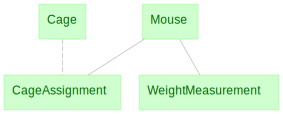

In [1]:
import datajoint as dj
schema = dj.Schema('mouse_cage')

# Entity 1: Mouse - contains ONLY permanent mouse properties
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    date_of_birth : date          # ✓ Permanent property of mouse
    sex : enum('M', 'F')          # ✓ Permanent property of mouse
    """

# Entity 2: Cage - contains ONLY cage properties
@schema
class Cage(dj.Manual):
    definition = """
    cage_id : int
    ---
    location : varchar(50)        # ✓ Property of cage
    capacity : int                # ✓ Property of cage
    """

# Entity 3: CageAssignment - represents the relationship (changeable over time)
@schema
class CageAssignment(dj.Manual):
    definition = """
    -> Mouse
    assignment_date : date        # Part of primary key - tracks assignment history
    ---
    -> Cage
    """

# Entity 4: WeightMeasurement - time-series of measurements
@schema
class WeightMeasurement(dj.Manual):
    definition = """
    -> Mouse
    measurement_date : date        # Part of primary key - tracks measurement history
    ---
    weight : decimal(5,2)         # ✓ Weight at this specific date
    """

dj.Diagram(schema)


**Why this is better:**

1. **✅ Rule 1 (One entity per table)**: Four distinct entity types, each in its own table
2. **✅ Rule 2 (Attributes describe only that entity)**: Mouse table has only mouse properties; Cage table has only cage properties
3. **✅ Rule 3 (Separate changeable attributes)**: Cage assignments and weights are in separate tables
4. **No updates needed**: Moving a mouse means DELETE old assignment + INSERT new assignment
5. **No redundancy**: Cage properties stored once, referenced by assignments
6. **History preserved**: Can track all past cage assignments and weight measurements
7. **Immutable entities**: Mouse and Cage entities never change once created


## The Workflow Immutability Principle

A key insight in DataJoint's Entity-Workflow Model: **workflow artifacts are immutable once created**.

### Workflow Entities as Immutable Artifacts

**Concept**: Each row (tuple) represents an immutable workflow artifact created at a specific workflow step. Once created, these artifacts are not modified—only created or destroyed.

**Operations:**
- ✅ **INSERT**: Create new workflow entities
- ✅ **DELETE**: Remove workflow entities and their downstream artifacts
- ❌ **UPDATE**: Avoided by design

### Why Workflow Immutability Matters

1. **Foreign keys reference complete workflow artifacts**: When a table references another via foreign key, it references the entire workflow entity created at a specific step. Updates can break these workflow relationships in subtle ways.

2. **Workflow execution dependencies**: In computational workflows, downstream entities are created from upstream entities. Updating upstream entities invalidates downstream workflow artifacts, but foreign key constraints won't detect this. Deletion forces you to explicitly address workflow dependencies.

3. **Workflow provenance and audit trails**: Immutable workflow artifacts naturally preserve the history of workflow execution. Changes are represented as new workflow artifacts, not modifications to existing ones.

4. **Parallel workflow execution**: Immutable workflow artifacts can be safely read by multiple processes without locks, enabling parallel workflow execution.


### Example: Data Pipeline and Immutability

Consider an image processing pipeline:

```
RawImage → PreprocessedImage → SegmentedCells → CellActivity
```

**If you UPDATE `RawImage` parameters:**
- ✗ All downstream data (`PreprocessedImage`, `SegmentedCells`, `CellActivity`) becomes invalid
- ✗ No error is raised—the inconsistency is silent
- ✗ Results are now based on mismatched inputs

**If you DELETE and re-INSERT `RawImage`:**
- ✓ Foreign key constraint prevents deletion while downstream data exists
- ✓ Forces you to delete the entire downstream pipeline first
- ✓ Then recompute everything with correct parameters
- ✓ Data dependencies are explicit and enforced

This is why normalization naturally leads to immutability: properly normalized schemas make data dependencies explicit through foreign keys, and immutability ensures those dependencies remain valid.


## Additional Example: E-commerce System

Another domain to illustrate the principles:


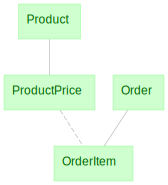

In [5]:
schema = dj.Schema('ecommerce')

# Permanent product properties
@schema
class Product(dj.Manual):
    definition = """
    product_id : int
    ---
    name : varchar(100)           # ✓ Permanent
    description : varchar(500)    # ✓ Permanent
    manufacturer : varchar(100)   # ✓ Permanent
    # NOT current_price - prices change!
    """

# Changeable pricing - separate entity
@schema
class ProductPrice(dj.Manual):
    definition = """
    -> Product
    effective_date : date         # When this price became effective
    ---
    price : decimal(10,2)
    """

@schema
class Order(dj.Manual):
    definition = """
    order_id : int
    """

# Customer orders reference the product, not a specific price
@schema
class OrderItem(dj.Manual):
    definition = """
    -> Order
    item_number : int
    ---
    -> ProductPrice               # Which price was in effect
    quantity : int
    """

dj.Diagram(schema)

**Key insight**: Price is a time-varying property, so it becomes its own entity rather than an attribute of Product. Order items reference both the specific product price and, transitively, the product itself, preserving historical accuracy.


## Classical vs. DataJoint Normalization

Both approaches achieve the same goal—well-structured, anomaly-free databases—but through different reasoning:

| Aspect | Classical (Codd) | DataJoint |
|--------|------------------|-----------|
| **Foundation** | Functional dependencies between attributes | Entities and their intrinsic properties |
| **Question** | "What attributes determine what other attributes?" | "What entity types exist and what are their properties?" |
| **Method** | Identify dependencies, decompose to eliminate violations | Design tables representing coherent entity types |
| **Era** | Pre-Entity-Relationship model (1970s) | Post-ER model (leverages intuitive entity thinking) |
| **Complexity** | Requires formal analysis of dependencies | Natural mapping to domain understanding |
| **Result** | Same normalized structure | Same normalized structure |

**The key difference**: DataJoint's entity-centric approach is easier to understand and apply because it maps directly to how we conceptualize domains—as collections of entities with properties—rather than as abstract attribute dependencies.


## Summary: DataJoint's Entity-Workflow Model

### The Core Principle

> **Every table represents an entity type created at a specific workflow step, and all attributes describe that entity as it exists at that workflow step.**

### Three Practical Rules for Workflow-Based Normalization

1. **One Workflow Step Per Table**
   - Each table represents exactly one workflow step where entities are created
   - Don't mix different workflow steps

2. **Attributes Describe Only That Workflow Entity**
   - Every attribute describes the entity at this specific workflow step
   - Not properties from other workflow steps (use foreign keys for workflow dependencies)

3. **Separate Entities by Workflow Steps**
   - Model each workflow step as a separate table
   - Entities created at different workflow steps should be in different tables

### The Workflow Immutability Principle

- Workflow entities are **immutable**: use INSERT and DELETE, not UPDATE
- Foreign keys reference complete workflow artifacts, not just IDs
- Ensures workflow execution consistency and dependency tracking
- Naturally preserves workflow provenance and audit trails

### Design Questions to Ask

For each table:
1. What workflow step does this represent?
2. Are all attributes available when this workflow step executes?
3. Are all entities created at the same workflow step?

If the answer to any question is "no," the table needs restructuring according to workflow execution steps.


### Benefits of the Entity-Workflow Model

When these principles are followed:

- ✅ **Workflow Integrity**: Each workflow artifact created in exactly one place
- ✅ **No Anomalies**: Update, insertion, and deletion anomalies eliminated
- ✅ **Workflow Consistency**: Changes propagate correctly through workflow dependencies
- ✅ **Maintainability**: Changes are localized to specific workflow steps
- ✅ **Clear Structure**: Schema reflects workflow execution steps intuitively
- ✅ **Workflow Immutability**: Workflow artifacts remain stable; changes are tracked explicitly
- ✅ **Workflow Provenance**: Workflow execution history naturally preserved
- ✅ **Workflow Integrity**: Workflow dependencies are explicit and enforced

### Practical Application

When designing or reviewing a schema using the Entity-Workflow Model:

1. **Identify workflow steps** in your domain
2. **For each workflow step**, determine what entities are created
3. **Separate workflow steps** into distinct tables
4. **Model workflow dependencies** with foreign keys
5. **Extract entities created at different workflow steps** into separate tables
6. **Verify** each table passes the three-question test

This workflow-centric approach achieves the same rigor as classical normalization but is much more intuitive and practical for modeling computational workflows and scientific processes.
